<a href="https://colab.research.google.com/github/Matig91/Colab-projects/blob/main/CS%20231n%20Convolutional%20NN%20(Stanford)/2.4_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment2


# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise, you will implement a dropout layer and modify your fully connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [ ]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [ ]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Dropout: Forward Pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [ ]:
from builtins import range
import numpy as np

def affine_forward(x, w, b):
  # out = None
  N = x.shape[0]
  x_resh = x.reshape(N, -1)
  out    = np.dot(x_resh, w) + b
  cache  = (x, w, b)
  return out, cache

def affine_backward(dout, cache):
  # initial dout is usually One - then, it goes as per Chain Rule. Cache is used to make calculation
  # the case presented for Affine layer (Fully-connected layer)
  x, w, b = cache
  dx, dw, db = None, None, None
  # x  = x.reshape(x.shape[0], -1)
  x_reshaped = x.reshape(x.shape[0], -1)
  dx = (dout @ w.T).reshape(x.shape[0], *x.shape[1:])  # N x D = N x M | M x D
  dw = x_reshaped.T @ dout   # D x M = D x N | N x M
  db = np.sum(dout, axis=0)   # (M, )

  return dx, dw, db

def relu_forward(x):
    """ Computes the forward pass for a layer of rectified linear units (ReLUs).
    Input: - x: Inputs, of any shape. Returns a tuple of: - out: Output, of the same shape as x - cache: x  """
    out = None
    out = np.maximum(x, 0)
    cache = x
    return out, cache

def relu_backward(dout, cache):
    """ Computes the backward pass for a layer of rectified linear units (ReLUs).
    Input: - dout: Upstream derivatives, of any shape; - cache: Input x, of same shape as dout;  Returns: - dx: Gradient with respect to x """
    x = cache # ; dx = None;
    # print(x.shape)

    dx = dout * (x>0)
    # dx = dout.copy(); dx[x<0] = 0
    # dx = np.where(x > 0, dout, 0)
    return dx

def softmax_loss(x, y):
  """  Computes the loss and gradient for softmax classification.
  Inputs:    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
    class for the ith input.  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and 0 <= y[i] < C
  Returns a tuple of: - loss: Scalar giving the loss; - dx: Gradient of the loss with respect to x    """
  loss, dx = None, None
  N = x.shape[0]
  softmax  = np.exp(x - np.max(x,axis=1, keepdims=True))     # numerically stable exponents | Softmax = P
  softmax /= np.sum(softmax, axis=1, keepdims=True)
  loss     = -np.sum(np.log(softmax[np.arange(N), y])) / N

  softmax[np.arange(N), y] -= 1
  dx =  softmax / N
  return loss, dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """ FORWARD pass for BATCH NORMALIZATION.  During TRAINING THE SAMPLE mean and (UNCORRECTED)
    sample variance are computed from MINIBATCH STATISTICS and used to normalize the incoming data.
    During TRAINING we also keep an EXPONENTIALLY DECAYING RUNNING AVERAGES of the
    mean and variance of each feature, and these AVERAGES ARE USED to normalize data at TEST-TIME.
        At each TIMESTEP we UPDATE THE RUNNING AVERAGES for mean and variance using
    an exponential decay based on the MOMENTUM PARAMETER: RUNNING_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var
        Note that the batch normalization paper suggests a DIFFERENT TEST-TIME
    behavior: they compute sample mean and variance for each feature using a
    large number of TRAINING IMAGES RATHER THAN USING A RUNNING AVERAGE. For this implementation we have chosen to use running averages
    instead since they do not require an additional estimation step; the torch7 implementation of batch normalization also uses running averages.
    Input:  - x: Data of shape (N, D) - gamma: Scale parameter of shape (D,); - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys;    - mode: 'train' or 'test'; required    - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.     - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features
    Returns a tuple of:    - out: of shape (N, D); - cache: A TUPLE of values needed in backward pass """

    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))
    out, cache = None, None

    if mode == "train":
      # TODO: Implement the training-time forward pass for batch norm
      """ Use MINIBATCH STATISTICS to compute the MEAN and VARIANCE, use
      these statistics to normalize the INCOMING DATA, and SCALE AND SHIFT the normalized data using GAMMA and BETA.
      You should store the output in the variable OUT. Intermediates  needed for the BACKPROP – to be STORED in the CACHE.
      Use computed SAMPLE mean and variance to UPDATE RUNNING mean and  running variance using MOMENTUM, storing result in running_mean/ running_var
      Note that though you should be keeping track of the running  VARIANCE, you should normalize the data
      based on the standard DEVIATION (square root of variance) instead! (see: https://arxiv.org/abs/1502.03167) """
      # Compute output
      mu  = x.mean(axis=0)        # batch mean for each feature (axis=0, aka mean img earlier)
      var = x.var(axis=0)         # batch variance for each feature
      std = np.sqrt(var + eps)    # batch standard deviation for each feature
      xm  = x - mu
      x_hat = xm / std
      out   = x_hat * gamma + beta    # scaled and shifted x_hat

      running_mean = momentum*running_mean + (1-momentum)*mu   # Update running average of variance
      running_var  = momentum*running_var  + (1-momentum)*var

      cache = (x, x_hat, xm, std, var, eps, gamma)

    elif mode == "test":              # TODO: Implement the TEST-time FWD-pass for BN.
      """ Use the RUNNING mean and variance to NORMALIZE the INCOMING DATA,
      then SCALE & SHIFT the normalized data using GAMMA and BETA. Store the result in the out variable. """
      std   = np.sqrt(running_var + eps)
      x_hat = (x-running_mean) / std
      out = x_hat*gamma + beta        # Broadcasted on examples, same gamma per each feature(-wise)
    else:
      raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"]  = running_var
    return out, cache

def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization. Write out Computation Graph for batchNorm on paper
    and propagate Gradients backward through Interm.Nodes. Inputs: - dout: Upstream derivatives, shape=(N, D);
    - cache: Intermediates var from batchnorm_forward.     Returns a tuple of: - dx: Grad w.r.t inputs x; shape=(N, D)
    - dgamma: Grad w.r.t.gamma (scale),shape=(D,);         - dbeta: Grad w.r.t shift param.beta; shape=(D,)    """
    dx, dgamma, dbeta = None, None, None
    # TODO: Backwrd pass for batchNorm-n (store results in dx, dgamma, and dbeta vars)
    # out = gamma * x_hat + beta = (N x D) x (D, 1)-> (N x D)
    x, x_hat, xm, std, var, eps, gamma = cache; N, D = dout.shape # xm = x-mu
    [gamma, dbeta] = np.atleast_2d(gamma, dbeta)
    dbeta  = dout.sum(axis=0)        # dbeta(D,) = dout/N x D/.sum(axis=0)
    dgamma = (dout * x_hat).sum(axis=0)            # dgamma(D,)= (N x D) x (N x D)
    # dgamma = dl/dg = dl/ds * ds/dg(global x local) = dout * (g * x_hat)' = dout * x_hat
    dxn = gamma * dout                                  # step 8
    dxm_l = dxn / std                                   # step 7 (left), std = ivar
    dstd = -np.sum((dxn * xm), axis=0) / (std * std)    # step 6 & 7(down)
    dvar = 0.5 * dstd / std                             # step 5
    # dxm_d = (2.0 / N) * xm * dvar                     # step 4-3
    dxm_d = 2.0 * xm /N * (np.ones((N,D)) * dvar)       # step 4-3 (exp.)
    dmu = -np.sum(dxm_l+dxm_d, axis=0)                  # step 2 (down)
    dx  = dxm_l+dxm_d + dmu/N                           # step
    return dx, dgamma, dbeta

def batchnorm_backward_alt(dout, cache):
    """Alternative BN backward pass.  Work out the derivatives on paper and simplify as much as possible toward simple expression for the backward pass.  Note: expect to receive the same cache variable. but might not use all of the values in the cache. """
    dx, dgamma, dbeta = None, None, None
    x, x_hat, xm, std, var, eps, gamma = cache; N, D = dout.shape # xm = x-mu
    # TODO: Implement the backward pass for batch normalization.
    """Store the results in the dx, dgamma, and dbeta variables. After computing the gradient with respect to the centered inputs,
    you should be able to compute gradients with respect to the inputs in a single statement; our implementation fits on a single 80-character line."""
    dbeta  = dout.sum(axis=0)
    dgamma = (dout * x_hat).sum(axis=0)
    dx = (1. / N) * gamma * (var + eps)**(-1. / 2.) * (N * dout - np.sum(dout, axis=0)-xm * (var + eps)**(-1.0) * np.sum(dout * xm, axis=0))
    return dx, dgamma, dbeta

def layernorm_forward(x, gamma, beta, ln_param):
    """Forward pass for layer normalization. During both training and test-time, the incoming data is NORMALIZED per data-point,
    before being SCALED by gamma and beta parameters identical to that of batch normalization.
    Note that IN CONTRAST to Batch Normalization, the behavior during train VS. test-time for layer normalization are IDENTICAL,
    and we do not need to keep track of running averages of any sort.
    Input:  - x: Data of shape (N, D);  - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,);  - ln_param: Dictionary with the following keys; - eps: Constant for numeric stability
    Returns a tuple of:    - out: of shape (N, D)  - cache: A tuple of values needed in the backward pass   """
    out, cache = None, None
    eps = ln_param.get("eps", 1e-5)
    # TODO: Implement the Training-time fwd pass for layer norm. Normalize the incoming data, and scale and  shift the normalized data using gamma and beta.
    # HINT: this can be done by slightly modifying your training-time implementation of  batch normalization, and inserting a line or two of well-placed code.
    # In particular, can you think of any MATRIX TRANSFORMATIONS you could perform, that would enable you to copy over the batch norm code and leave it almost unchanged?

    mu  = x.mean(axis=1, keepdims=True)
    var = x.var(axis=1, keepdims=True)         # features variance for each feature
    std = np.sqrt(var + eps)    # features standard deviation for each feature
    x_hat = (x - mu) / std; xm = x - mu
    out   = x_hat * gamma + beta
    cache = (x, x_hat, xm, std, var, eps, gamma, mu)  # (x, mu, var, std, eps, x_hat)
    return out, cache

def layernorm_backward(dout, cache):
    """Backward pass for layer normalization. For this implementation, you can heavily rely on the work you've done already
    for batch normalization.  Inputs: - dout: Upstream derivatives, of shape (N, D); - cache: Variable of intermediates from layernorm_forward.
    Returns a tuple of: - dx: Gradient with respect to inputs x, of shape (N, D)  - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)    """
    dx, dgamma, dbeta = None, None, None
    # x, mu, var, std, eps, x_hat = cache
    x, x_hat, xm, std, var, eps, gamma, mu = cache
    xm = x - mu

    # TODO: Implement the backward pass for layer norm. # HINT: this can be done by slightly
    # modifying your training-time implementation of Batch Normalization. The hints to the forward pass still apply!
    N, D = x.shape
    dbeta  = dout.sum(axis=0, keepdims=True)
    dgamma = (dout * x_hat).sum(axis=0, keepdims=True)
    dx = (1. / D) * (var + eps)**-0.5 * (D * gamma * dout - np.sum(dout* gamma, axis=1, keepdims=True) - xm * (var + eps)**(-1) * np.sum(dout*xm* gamma, axis=1, keepdims=True))

    # dxn = dout * gamma; xn =  xm * istd        #
    # dx   = dxn - dxn.mean(-1, keepdims=True) - xn * (dxn*xn).mean(-1, keepdims=True)
    # dx  *= istd

    return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
    """Forward pass for inverted dropout.    Note that this is different from the vanilla version of dropout.
    Here, p is the probability of keeping a neuron output, as opposed to the probability of dropping a neuron output.
    See http://cs231n.github.io/neural-networks-2/#reg for more details.
    Inputs:    - x: Input data, of any shape    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We KEEP each neuron output with probability p.    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.     - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but no    in real networks.
    Outputs:    - out: Array of the same shape as x.    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.    """

    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask = None
    out = None

    if mode == "train":
        # TODO: Implement training phase forward pass for inverted dropout. Store the dropout mask in the mask variable.                        #
        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask

    elif mode == "test":
        # TODO: Implement the test phase forward pass for inverted dropout.   #
        out = x

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """Backward pass for inverted dropout.
    Inputs:  - dout: Upstream derivatives, of any shape  - cache: (dropout_param, mask) from dropout_forward. """

    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":
        # TODO: Implement training phase backward pass for inverted dropout   #
        dx = dout * mask

    elif mode == "test":
        dx = dout
    return dx

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10

for p in [0.25, 0.4, 0.7]:
    out, _      = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()
x, out

Running tests with p =  0.25
Mean of input:  9.776660556859152
Mean of train-time output:  10.407980245113198
Mean of test-time output:  9.776660556859152
Fraction of train-time output set to zero:  0.73
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  9.776660556859152
Mean of train-time output:  8.406947143906994
Mean of test-time output:  9.776660556859152
Fraction of train-time output set to zero:  0.66
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  9.776660556859152
Mean of train-time output:  10.473045909630718
Mean of test-time output:  9.776660556859152
Fraction of train-time output set to zero:  0.25
Fraction of test-time output set to zero:  0.0



(array([[10.41794341, 11.39710028,  8.21409569,  9.29117227,  9.92527468,
          9.22498323,  9.8502021 , 11.86172902,  8.5744707 ,  9.6236433 ],
        [ 9.65772461, 10.29490764,  9.16267627, 10.95218767, 11.32931659,
         10.52465245,  9.85190002, 10.88953195, 10.12444653, 10.99109251],
        [10.03514666, 10.26207083, 10.14320173, 10.90101716, 10.23185863,
          9.20274207, 10.12001014,  9.34320392, 10.26917456, 10.333667  ],
        [10.27423503, 10.76215717,  9.30449942, 10.29214712,  9.61510058,
         10.1228747 ,  8.57095503, 10.70286283,  9.14149053,  8.85957021],
        [ 8.41464003,  9.98469862,  9.67843917, 10.56834936,  9.80038278,
         11.27286625, 11.27292534, 11.58102968,  8.24373285, 10.9217743 ],
        [ 9.3246946 ,  8.56556384, 10.47021125, 10.03196734, 10.04448574,
         10.47824879,  7.48664819,  8.84259755,  9.29529587,  8.95021121],
        [ 8.09204411, 10.49258765, 10.83736166,  8.5711866 ,  9.81017573,
          8.85905057,  7.8742924

((array([ 2.,  3.,  8.,  8., 14., 20., 25., 11.,  7.,  2.]),
  array([ 7.28515732,  7.74281449,  8.20047166,  8.65812883,  9.115786  ,
          9.57344317, 10.03110034, 10.48875751, 10.94641468, 11.40407185,
         11.86172902]),
  <BarContainer object of 10 artists>),
 (array([25.,  0.,  0.,  0.,  0.,  0.,  5., 21., 37., 12.]),
  array([ 0.        ,  1.69453272,  3.38906544,  5.08359815,  6.77813087,
          8.47266359, 10.16719631, 11.86172902, 13.55626174, 15.25079446,
         16.94532718]),
  <BarContainer object of 10 artists>))

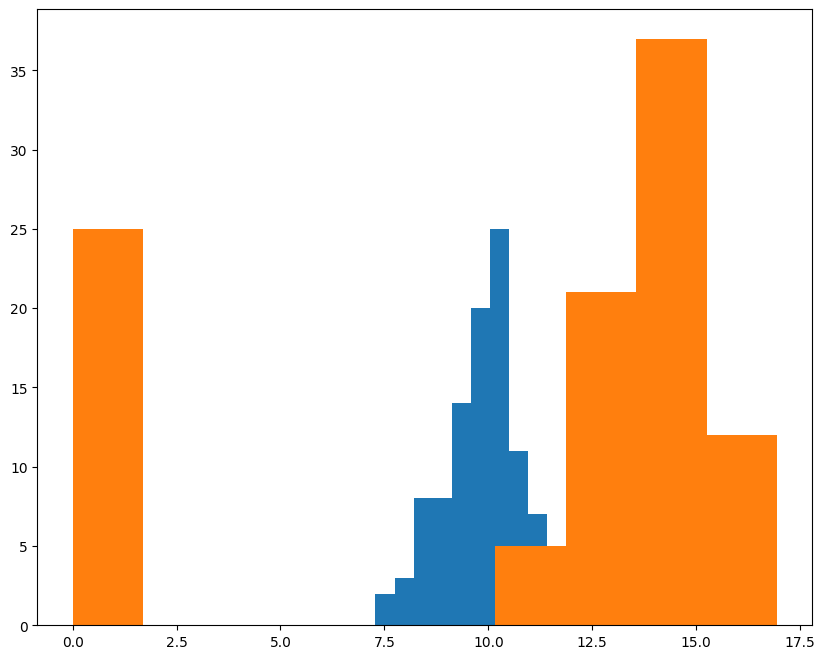

In [ ]:
plt.hist(x.reshape(-1, 1)), plt.hist(out.reshape(-1, 1))

# Dropout: Backward Pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less.
print('dx relative error: ', rel_error(dx, dx_num))
dx

dx relative error:  5.44560814873387e-11


array([[-0.        , -0.        , -0.        ,  0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [-0.        , -0.        , -0.        ,  4.27173787, -0.        ,
        -0.        , -1.52048969,  0.90418628, -0.        ,  0.        ],
       [-0.        , -0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        , -0.        ,  0.        ],
       [-5.6041004 ,  0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [-0.        , -0.20420725, -0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        , -0.        , -0.        ],
       [-9.27853923,  0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        , -0.        , -0.        ,
        -5.07079302, -0.        , -0.        

## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:
[FILL THIS IN]


# Fully Connected Networks with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the network receives a value that is not 1 for the `dropout_keep_ratio` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout_keep_ratio in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout_keep_ratio)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        weight_scale=5e-2,
        dtype=np.float64,
        dropout_keep_ratio=dropout_keep_ratio,
        seed=123
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    # Relative errors should be around e-6 or less.
    # Note that it's fine if for dropout_keep_ratio=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Initial loss:  2.300479089768492
W1 relative error: 1.03e-07
W2 relative error: 2.21e-05
W3 relative error: 4.56e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 1.69e-10

Running check with dropout =  0.75
Initial loss:  2.3016482157750753
W1 relative error: 3.44e-07
W2 relative error: 5.01e-06
W3 relative error: 1.40e-07
b1 relative error: 1.48e-08
b2 relative error: 9.48e-10
b3 relative error: 1.28e-10

Running check with dropout =  0.5
Initial loss:  2.294963257976082
W1 relative error: 1.20e-07
W2 relative error: 5.54e-07
W3 relative error: 3.75e-07
b1 relative error: 3.35e-09
b2 relative error: 4.40e-09
b3 relative error: 1.44e-10



# Regularization Experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [ ]:
# Train two identical nets, one with dropout and one without.
np.random.seed(231)
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}

dropout_choices = [1, 0.25]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet(
        [500],
        dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule='adam',
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

1
(Iteration 1 / 125) loss: 7.856644
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000


/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/layers.py:53: RuntimeWarning: divide by zero encountered in log
  loss     = -np.sum(np.log(softmax[np.arange(N), y])) / N


(Epoch 1 / 25) train acc: 0.348000; val_acc: 0.213000
(Epoch 2 / 25) train acc: 0.446000; val_acc: 0.249000
(Epoch 3 / 25) train acc: 0.520000; val_acc: 0.270000
(Epoch 4 / 25) train acc: 0.586000; val_acc: 0.252000
(Epoch 5 / 25) train acc: 0.636000; val_acc: 0.282000
(Epoch 6 / 25) train acc: 0.612000; val_acc: 0.234000
(Epoch 7 / 25) train acc: 0.626000; val_acc: 0.258000
(Epoch 8 / 25) train acc: 0.686000; val_acc: 0.264000
(Epoch 9 / 25) train acc: 0.714000; val_acc: 0.243000
(Epoch 10 / 25) train acc: 0.740000; val_acc: 0.252000
(Epoch 11 / 25) train acc: 0.778000; val_acc: 0.290000
(Epoch 12 / 25) train acc: 0.764000; val_acc: 0.257000
(Epoch 13 / 25) train acc: 0.818000; val_acc: 0.275000
(Epoch 14 / 25) train acc: 0.874000; val_acc: 0.282000
(Epoch 15 / 25) train acc: 0.822000; val_acc: 0.289000
(Epoch 16 / 25) train acc: 0.888000; val_acc: 0.285000
(Epoch 17 / 25) train acc: 0.914000; val_acc: 0.291000
(Epoch 18 / 25) train acc: 0.880000; val_acc: 0.270000
(Epoch 19 / 25) tra

In [ ]:
# Plot train and validation accuracies of the two models.
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
[FILL THIS IN]
